# Bluesky interfacing demo

This Jupyter Notebook demonstrates the use of Bluesky as a Python package and how it can be used to generate aircraft trajectories.

**Note:** Make sure that you have Bluesky installed as a package in your Python environment.

Let's start by importing the relevant modules.

In [1]:
import numpy as np
import pandas as pd

import bluesky as bs
from bluesky import traffic as tr
from bluesky import settings
from bluesky.traffic.route import Route
from bluesky.navdatabase import Navdatabase
from bluesky.simulation import Simulation
from bluesky.traffic.performance.perfbase import PerfBase

Using Python-based geo functions


Once the modules are imported, we have to initialize the settings and create the Traffic, Navdatabase and Simulation objects. These are singletons and, thus, exist only once. We assign these to the bluesky module (here imported as *bs*).

In [2]:
# initialize global settings
settings.init('')

# manually set the performance model to the one defined in the settings
PerfBase.setdefault(settings.performance_model)

print("Using {} as performance model".format(settings.performance_model))

# manually create singletons
traf = tr.Traffic()
bs.traf = traf

navdb = Navdatabase()
bs.navdb = navdb

sim = Simulation()
bs.sim = sim
sim.ffmode = True

Reading config from settings.cfg
Using openap as performance model
Loading global navigation database...
Reading cache: data/cache\py3\navdata.p


Define the route that should be flown. As an example, we define the route with lat/lon for a go-around at Zurich airport.

In [3]:
route_data = {}
route_data['Lat'] = [47.66459656, 47.65553284, 47.64628601, 47.63291931, 47.61758578, 47.60273562, 47.58755959, 47.57284908, 47.56009377, 47.54873502, 47.53884888, 47.52853135, 47.51779175, 47.51312256, 47.51321566, 47.52266577, 47.53318657, 47.54704285, 47.5655365, 47.58346299, 47.59957006, 47.61177063, 47.6232186, 47.63214111, 47.62922384, 47.62271118, 47.61497498, 47.59831238, 47.58188021, 47.56782532, 47.55482483, 47.54305565, 47.53207397, 47.52220024, 47.51358808, 47.50520325, 47.49645686, 47.48789125, 47.47892761, 47.47219563, 47.46855354, 47.46626773, 47.46449909, 47.4630886]
route_data['Lon'] = [8.24105072, 8.272293091, 8.30216217, 8.327774048, 8.350454477, 8.370948205, 8.392075759, 8.411794809, 8.429401104, 8.444683368, 8.457962036, 8.472360464, 8.488586426, 8.509967511, 8.534475473, 8.555814303, 8.575955904, 8.588493347, 8.578948975, 8.562715971, 8.542222243, 8.519210815, 8.497431828, 8.474510193, 8.448204627, 8.422737122, 8.399047852, 8.392456055, 8.403414213, 8.419921875, 8.436882019, 8.452500563, 8.467506409, 8.481163612, 8.492854192, 8.504516602, 8.516305777, 8.528066782, 8.540290833, 8.549556255, 8.554521561, 8.556650602, 8.557264511, 8.558572622]
route_data['Alt'] = [1866.9, 1790.7, 1676.4, 1584.96, 1577.34, 1516.38, 1379.22, 1280.16, 1127.76, 1082.04, 1074.42, 1188.72, 1371.6, 1524, 1577.34, 1584.96, 1592.58, 1592.58, 1592.58, 1584.96, 1584.96, 1592.58, 1592.58, 1577.34, 1470.66, 1386.84, 1310.64, 1287.78, 1287.78, 1196.34, 1112.52, 998.22, 906.78, 838.2, 762, 693.42, 624.84, 548.64, 464.82, 472.44, 472.44, 472.44, 472.44, 472.44]
route_data['Spd'] = [135.29889, 123.98111, 119.865555, 121.40889, 120.89445, 114.206665, 113.17778, 105.975555, 92.6, 78.19556, 74.08, 81.79667, 85.39778, 86.94111, 95.68667, 96.20111, 95.172226, 96.20111, 117.80778, 118.83667, 116.77889, 105.46111, 100.316666, 101.34556, 104.43222, 101.86, 99.28778, 100.83111, 98.25889, 100.83111, 94.14333, 85.39778, 81.79667, 68.935555, 64.30556, 64.82, 65.33444, 66.87778, 67.39222, 62.247776, 62.247776, 62.247776, 62.247776, 62.247776]

route_data = pd.DataFrame(route_data)

Now that everything is initialized and we have our route, we can get started and and generate some traffic. Here, we generate 3 aircraft of the type *A320*.

In [4]:
# generate some trajectories
n = 3

# aircraft IDs (called "000", "001", ...)
acids = [str(i).zfill(3) for i in range(n)]

# aircraft type
actypes = "A320"

# create traffic, we pass each traffic element the initial conditions such as
# initial position, speed etc.
# This could also be done vectorized, but we initialize here in a loop instead
ic = route_data.head(1)
for i in range(n):
    traf.cre(acid=acids[i], actype=actypes, aclat=ic['Lat'], aclon=ic['Lon'],
             achdg=112, acalt=ic['Alt'], acspd=ic['Spd'])

Next we want to assign some waypoints to the traffic. In this example we assign the same route to all the flights. This is just for the sake of simplicity and it obviously wouldn't make a lot of sense in a practical application, but it should highlight how waypoints are added.

In [5]:
m2ft = 0.3048

# iterate over traffic and add the same waypoints
for acid in acids:
    idx = bs.traf.id.index(acid)

    # set the origin (not needed if initialized in flight)
    # traf.ap.setorig(idx, 'LSZH')

    # add waypoints
    # Note that not all the parameters (constraints at the waypoint) need to be
    # passed. E.g. if you don't have a prescribed speed or altitude, you don't
    # have to pass it to the function.
    for _, wp in route_data.iterrows():
        wp_str = str(wp['Lat']) + ', ' + str(wp['Lon'])
        Route._routes.get(acid).addwptStack(idx, wp_str, wp['Alt'], wp['Spd'])
    
    # Alternatively, you can also pass a name of a waypoint, e.g.
    # Route._routes.get(acid).addwptStack(idx, 'BPK', 6000 / m2ft)

    # you can also set the way the waypoint should be flown (FLYBY, FLYOVER,
    # or FLYTURN)
    Route._routes.get(acid).addwptMode(idx, 'FLYOVER')

    # you can also set a destination
    traf.ap.setdest(idx, 'LSZH')

    # in order for VNAV to work properly, selected vertical speed cannot be 0
    traf.ap.selvspdcmd(idx, 1500 * m2ft / 60)

    # turn on VNAV
    traf.ap.setVNAV(idx, True)

# turn off traffic resolution for all flights
traf.cr.setresooff(range(n))

True

Now that all our traffic has a route to fly, it's time to start the simulation.

In [6]:
# simulation time step
bs.sim.simdt = 1

# initial simulation time
bs.sim.simt = 0

# we'll run the simulation for up to 4000 seconds
t_max = 10000

ntraf = traf.ntraf
n_steps = t_max//bs.sim.simdt+1
t = np.linspace(0, t_max, n_steps)

# allocate some empty arrays for the results
res = np.zeros((n_steps, 4, ntraf))
trajs = {}

# iteratively simulate the traffic
for i in range(n_steps):

    # save the results from the simulator in the results array,
    # here we keep the latitude, longitude, altitude and TAS
    res[i] = [bs.traf.lat,
              bs.traf.lon,
              bs.traf.alt,
              bs.traf.tas]

    # check if an aircraft arrived at the destination
    finished = np.logical_not(np.logical_and(bs.traf.swlnav,
                                             bs.traf.swvnav,
                                             bs.traf.swvnavspd))

    # take the traffic out of the results if it arrived
    if any(finished):
        idxs = np.argwhere(finished)
        for idx in reversed(idxs):
            print('Removing flight {}'.format(acids[idx[0]]))

            # insert results of finished trajectory into dict
            trajs[acids[idx[0]]] = res[:i+1, :, idx[0]]

            # delete traffic object
            bs.traf.delete(idx[0])

            # delete from results
            res = np.delete(res, idx[0], 2)

            # delete AC ID from list
            del acids[idx[0]]


    # increment simulation time
    bs.sim.simt += bs.sim.simdt

    # let bluesky do one simulation step
    traf.update()

Removing flight 002
Removing flight 001
Removing flight 000


Finally, we do a bit of plotting to visualize the results. Again, the three trajectories are the same since we passed the same route to them, but this, of course, can be easily changed.

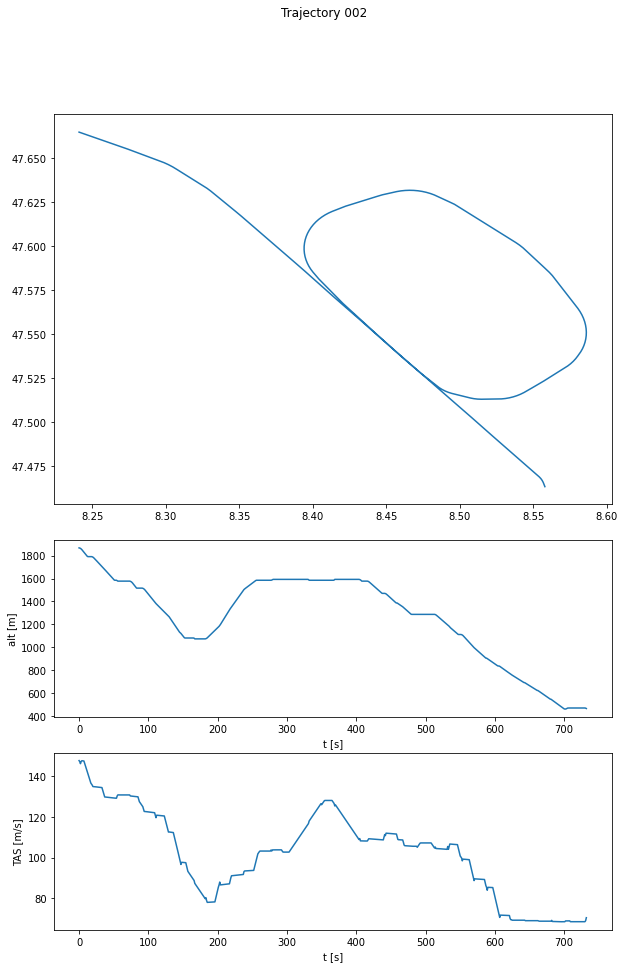

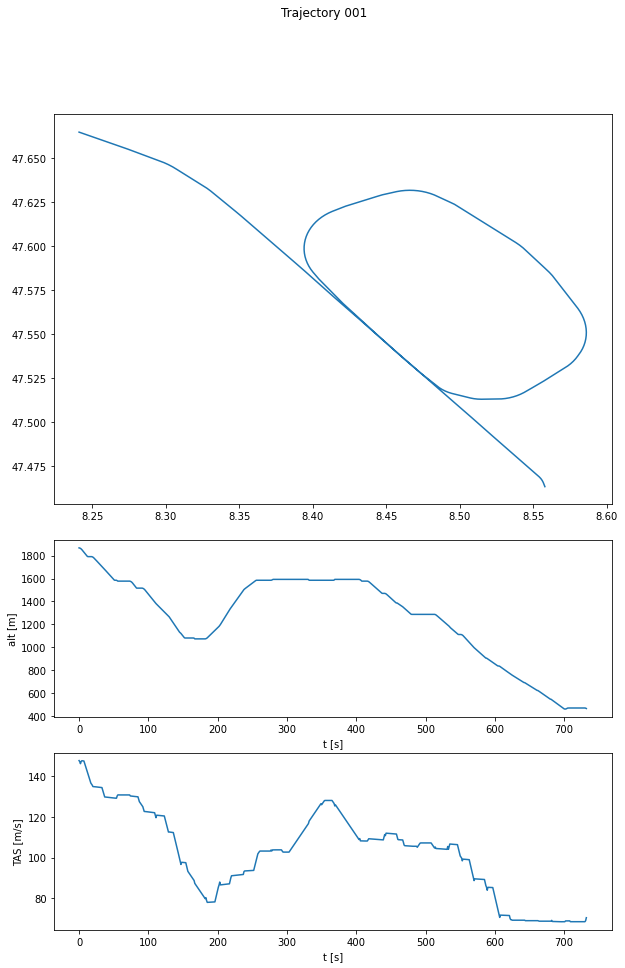

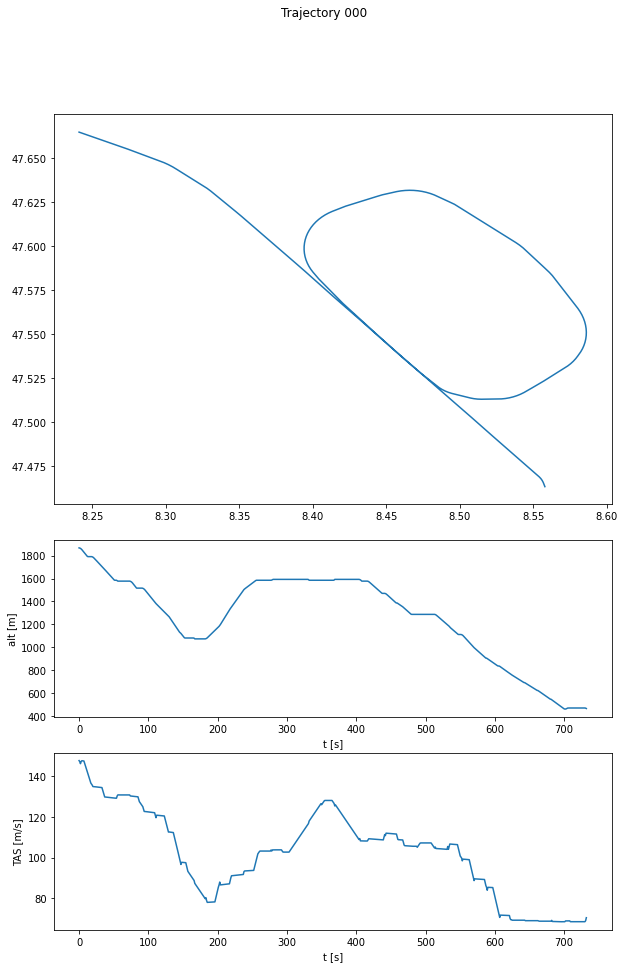

In [7]:
# plot
import matplotlib.pyplot as plt

for acid, traj in trajs.items():
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((4, 1), (2, 0))
    ax3 = plt.subplot2grid((4, 1), (3, 0))

    ax1.plot(traj[:, 1], traj[:, 0])

    t_slice = t[range(len(traj[:, 0]))]

    ax2.plot(t_slice, traj[:, 2])
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('alt [m]')

    ax3.plot(t_slice, traj[:, 3])
    ax3.set_xlabel('t [s]')
    ax3.set_ylabel('TAS [m/s]')
    
    fig.suptitle('Trajectory {}'.format(acid))

# for idx in range(len(acids)):
#     fig = plt.figure(figsize=(10, 15))
#     ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
#     ax2 = plt.subplot2grid((4, 1), (2, 0))
#     ax3 = plt.subplot2grid((4, 1), (3, 0))

#     ax1.plot(res[:, 1, idx], res[:, 0, idx])

#     ax2.plot(t, res[:, 2, idx])
#     ax2.set_xlabel('t [s]')
#     ax2.set_ylabel('alt [m]')

#     ax3.plot(t, res[:, 3, idx])
#     ax3.set_xlabel('t [s]')
#     ax3.set_ylabel('TAS [m/s]')
    
#     fig.suptitle('Trajectory {}'.format(acids[idx]))
